In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm
from os import walk
from scipy.stats import lognorm
from scipy import stats as sps

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now().date() - timedelta(days=1)

In [3]:
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum', 'Refdatum'])
df_rki = df_raw.copy()
#df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])
#df_rki['Refdatum'] = pd.to_datetime(df_rki['Refdatum'])
df_rki['week'] = df_rki['Meldedatum'].dt.week
df_rki = df_rki.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')

f"Found {df_rki['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

'Found 160,648 cases downloaded at 2020-05-01_08h'

In [4]:
df_rki[:3]

,Unnamed: 0,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,week
0,0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,4404752,2020-03-14,1001,"01.05.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt,11
1,1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,4404753,2020-03-19,1001,"01.05.2020, 00:00 Uhr",0,-9,2020-03-13,0,1,1,Nicht übermittelt,12
2,2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,4404754,2020-03-19,1001,"01.05.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt,12


In [23]:
df_rki['Altersgruppe'].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [5]:
days_per_week = df_rki[['week', 'Meldedatum']].drop_duplicates()
weeks_ending = days_per_week.groupby('week')['Meldedatum'].max().reset_index()
weeks_ending.columns = ['week', 'last_dow']

n_days = days_per_week.groupby('week').size()
complete = n_days[n_days == 7]
min_complete_week = complete.index.min()
max_complete_week = complete.index.max()
min_complete_week, max_complete_week

(9, 17)

Text(0.5, 1.0, 'Altersgruppe 80+')

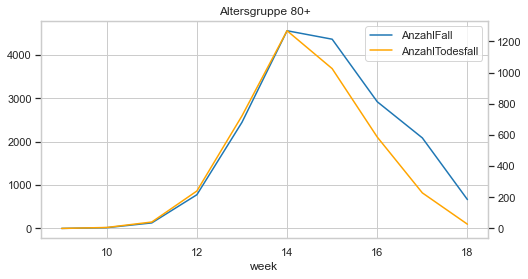

In [6]:
daily_totals = df_rki.query('week >= @min_complete_week and Altersgruppe == "A80+"')\
                     .groupby('week')[['AnzahlFall', 'AnzahlTodesfall']].sum()

def plot_on_2_axes(to_plot1, to_plot2):
    to_plot1.plot(figsize=(8,4))
    ax = plt.gca()
    ax2 = ax.twinx()
    to_plot2.plot(ax=ax2, color='orange')
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax2.grid(False)

plot_on_2_axes(daily_totals['AnzahlFall'], daily_totals['AnzahlTodesfall'])
plt.title('Altersgruppe 80+')

## Epidemilogical paramters

*Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data* Linton, Kobayashi, et al. 17th of Feb

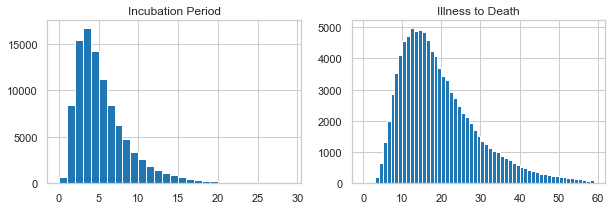

In [7]:
incubation = np.random.lognormal(1.525, .625, size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(incubation, bins=range(30))
axes[0].set_title('Incubation Period')
death = np.random.lognormal(2.865, .533, size=100000)
axes[1].hist(death, bins=range(60))
_= axes[1].set_title('Illness to Death')

In [8]:
# generation time
# Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing Ferretti, Fraser et al.

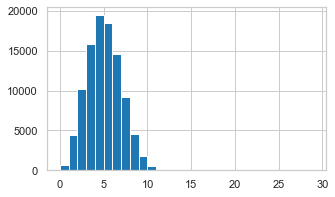

In [9]:
gen_time = np.random.weibull(2.826, size=100000) *  5.665
plt.figure(figsize=(5,3))
_= plt.hist(gen_time, bins=range(30))

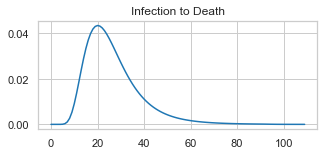

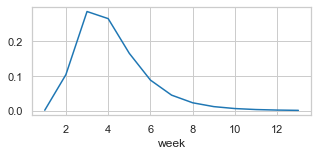

In [10]:
def lognorm_frame(mu, sigma):
    incubation_time = lognorm(s=sigma, scale=np.exp(mu))
    cdf = pd.Series(incubation_time.cdf(range(90)))
    daily_p = cdf - cdf.shift(1).fillna(0)
    return daily_p

cum_inc_time = lognorm_frame(1.525, 0.625)[:21]
cum_tt_death = lognorm_frame(2.865, 0.533)

infection_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
infection_to_death.plot(figsize=(5,2))
plt.title('Infection to Death')
plt.show()

week_starts = np.array(range(0, 92, 7))
cum_i_to_d = infection_to_death.cumsum() / infection_to_death.sum()
weekly_inf_death = (cum_i_to_d[week_starts] - cum_i_to_d[week_starts].shift(1).fillna(0))
weekly_inf_death.index = (weekly_inf_death.index / 7).astype(int)

weekly_inf_death[1:].plot(figsize=(5,2))
_= plt.xlabel('week')

In [24]:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})

## Crude cases based on deaths

Dropped age groups: 


Altersgruppe
A00-A04      1
A05-A14      0
unbekannt    4
Name: AnzahlTodesfall, dtype: int64

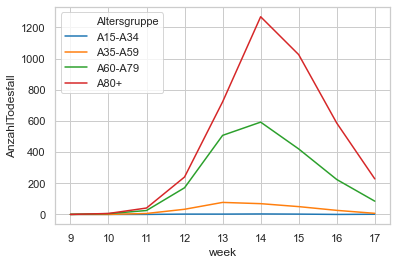

In [11]:
complete_weeks = df_rki.query('week >= @min_complete_week and week <= @max_complete_week')
weekly_by_age = complete_weeks.groupby(['week', 'Altersgruppe'])['AnzahlTodesfall'].sum().reset_index()
to_drop = weekly_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
print('Dropped age groups: ')
display(weekly_by_age[to_drop].groupby('Altersgruppe')['AnzahlTodesfall'].sum())
weekly_by_age['cartesian_key'] = True

weekly_by_age = weekly_by_age[~to_drop]
_= sns.lineplot(x='week', y='AnzahlTodesfall', hue='Altersgruppe', data=weekly_by_age)

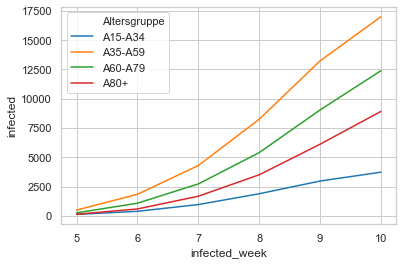

In [12]:
week_cutoff = 7

# some people die early some die late in a give week, 
# so they had between one a two weeks since the start of the last week
offset_case_factors = (weekly_inf_death + weekly_inf_death.shift(-1).fillna(0)) / 2
offset_case_factors = offset_case_factors[:week_cutoff + 1].to_frame().reset_index()
offset_case_factors.columns = ['week_offset', 'infection_factor']
offset_case_factors['cartesian_key'] = True
offset_merge = weekly_by_age.merge(offset_case_factors)
offset_merge['infected_week'] = offset_merge['week'] - offset_merge['week_offset']
offset_merge['deadly_infected'] = offset_merge['AnzahlTodesfall'] * offset_merge['infection_factor']

df_deadly_infection = offset_merge.groupby(['infected_week', 'Altersgruppe'])['deadly_infected'].sum().reset_index()

df_deadly_infection = df_deadly_infection.merge(mortality)
df_deadly_infection['infected'] = df_deadly_infection['deadly_infected'] / df_deadly_infection['mortality']
df_deadly_infection = df_deadly_infection.query('infected_week <= @max_complete_week - @week_cutoff')
df_deadly_infection = df_deadly_infection.merge(weeks_ending.reset_index(), left_on='infected_week', right_on='week')

# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})
df_deadly_infection = df_deadly_infection.merge(mortality)
df_deadly_infection['infected'] = df_deadly_infection['deadly_infected'] / df_deadly_infection['mortality']
_= sns.lineplot(x='infected_week', y='infected', hue='Altersgruppe', data=df_deadly_infection)

### Reported cases

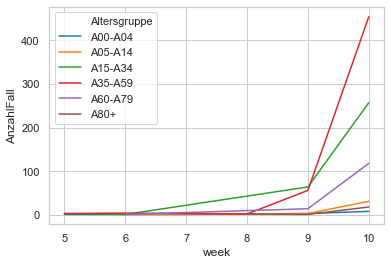

In [13]:
rep_cases_by_age = df_rki.query('week <= @max_complete_week - @week_cutoff').groupby(['Altersgruppe', 'week'])['AnzahlFall'].sum().reset_index()
sns.lineplot(x='week', y='AnzahlFall', hue='Altersgruppe', data=rep_cases_by_age)

## Bayesian cases based on deaths

$$ \text{deaths}(t)  = \sum_{k=0}^\text{cutoff} \operatorname{Pois}(\text{cases}(t -k) \cdot p_\text{death-delay}(k)) $$

In [162]:
age_group = 'A35-A59'

min_complete_week = weekly_by_age.query('Altersgruppe == @age_group and AnzahlTodesfall > 0')['week'].min()
# allow time for cases to lead to deaths at week min_complete_week
start_week = min_complete_week - 3
# from this week on deaths are censored 7 weeks to die plus a few days for reporting
end_week = max_complete_week - 5
n_weeks = end_week - start_week + 1
f'n_weeks: {n_weeks}, start_week: {start_week}, end_week: {end_week}'

'n_weeks: 5, start_week: 8, end_week: 12'

In [163]:
# this lower triangular matirx vectorizes the multiplication with r,
# which is composed of a starting value r_zero and it's changes over
# the following time points
TRIL = []
for i in range(1, n_weeks):
    row = list(range(1, i+1))
    row.reverse()
    n_zeros = n_weeks - i - 1
    if n_zeros > 0:
        row = np.concatenate([row, np.zeros(n_zeros)])
    TRIL.append(row[:16])
TRIL = np.array(TRIL)
print(TRIL.shape)
TRIL

(4, 4)


array([[1., 0., 0., 0.],
       [2., 1., 0., 0.],
       [3., 2., 1., 0.],
       [4., 3., 2., 1.]])

In [165]:
deaths = weekly_by_age.query('Altersgruppe == @age_group')
n_zeros = (n_weeks - len(deaths))
deaths = pd.concat([pd.Series([0] * n_zeros, 
                              index=range(start_week, start_week + n_zeros)), 
                    deaths.set_index('week')['AnzahlTodesfall']])
deaths.loc[min_complete_week:end_week]

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


11     6
12    33
dtype: int64

In [177]:
import theano

# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# in weeks
serial_interval = 1
group_mortality = mortality.set_index('Altersgruppe').loc[age_group].iloc[0]
#population = 20e6


if n_weeks - 1 > weekly_inf_death.shape[0]:
    death_delay = np.concatenate([weekly_inf_death.values, 
                              np.zeros(weekly_inf_death.shape[0])])
else:
    death_delay = weekly_inf_death.values[:n_weeks]
death_delay = pd.Series(death_delay)
DD = np.array([death_delay.shift(i).fillna(0).values for i in range(n_weeks)]).T

with pm.Model() as model:
    r_zero = pm.Normal('r_zero', 3, 0.2)
    
    r_mu = pm.Normal('r_mu', 0, .2)
    r_sigma = pm.Gamma('r_sigma', 10, 100)
    r_delta = pm.Normal('r_delta', r_mu, r_sigma, shape=n_weeks-2)
    r = pm.Deterministic('r', pm.math.concatenate([r_zero.flatten(), r_delta]))
    # substract 1 from the first entry
    beta = r - np.array([1] + [0] * (n_weeks - 2))
    
    # log_infection are modelled linearly with slope sum_0^t (r[t] - 1) 
    start_infections = pm.Gamma('start_infections', 1, 2)
    
    # TODO: add logit growth from SIR model, to keep the exp from exploding for high outliers <<<-----------!!!!!!!!!!!!!!!!!!!!!!!!!!!
    log_infection_following = start_infections * (1 + pm.math.dot(TRIL, beta / serial_interval)) 
    all_log_infections = pm.math.concatenate([start_infections.flatten(), log_infection_following])
    log_infections = pm.Deterministic('log_infections', all_log_infections)
    
    # obs_infection = df_rki.query('Altersgruppe == @age_group and \
    #                          week >= @min_complete_week and \
    #                          week <= @max_complete_week').groupby('week')['AnzahlFall'].sum()
    # obs_infection
    #pm.Poisson('obs_infection', np.exp(log_indections), observed=obs_infection)
    
    # the death delay matrix DD spreads infections out into the future 
    # weighted by the time to death probability on a future day
    expected_deaths = pm.Deterministic('expected_deaths', pm.math.dot(DD, np.exp(log_infections)) * group_mortality)
    
    obs_deaths = pm.Normal('obs_deaths', 
                            expected_deaths[min_complete_week - start_week:],
                            sigma=np.sqrt(expected_deaths[min_complete_week - start_week:]),
                            shape=n_weeks, 
                            observed=deaths.loc[min_complete_week:end_week])

In [179]:
def plot_sample_with_quantiles(sample_values, alpha=0.05):
    plot_with_q = pd.DataFrame(sample_values).apply(pd.Series.quantile, q=[alpha/2, 0.5, 1 - alpha/2]).T
    plot_with_q.index = plot_with_q.index + start_week
    plot_with_q[0.5].plot(label='prior median')
    plt.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label='95% prediction interval')

def sanity_check(true_values=None, obs_var_name='obs'):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=10000, model=model, vars=[obs_var_name])[obs_var_name]
    plt.figure(figsize=(16, 4))
    plot_sample_with_quantiles(y)
    plt.plot(true_values.values, label='true value')
    plt.ylim([-0.2, 5000])
    plt.legend(loc='upper left')
    return y
    

# And run the sanity check
#y = sanity_check(obs_cases, 'obs_deaths')
#np.median(y, axis=0).round(1)

In [180]:
with model:
    #print(model.test_point)
    trace = pm.sample(step_scale=0.05)#20000, tune=10000, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [start_infections, r_delta, r_sigma, r_mu, r_zero]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:08<00:00, 453.63draws/s]
The acceptance probability does not match the target. It is 0.8906673914077577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795881954102518, but should be close to 0.8. Try to increase the number of tuning steps.


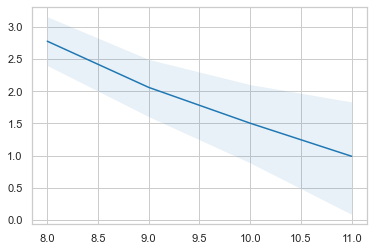

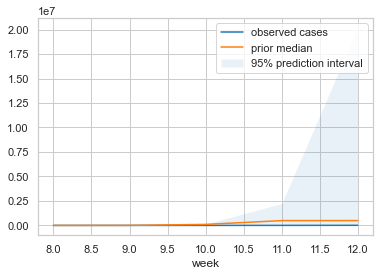

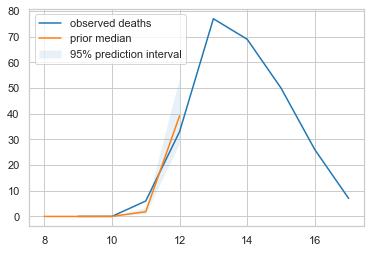

In [181]:
r_eff = np.cumsum(trace['r'], axis=1)
plot_sample_with_quantiles(r_eff)
plt.show()

obs_cases = df_rki.query('Altersgruppe == @age_group and \
                         week >= @start_week and \
                         week <= @end_week').groupby('week')['AnzahlFall'].sum()
obs_cases.plot(label='observed cases')
plot_sample_with_quantiles(np.exp(trace['log_infections']))
plt.legend()
plt.show()

pd.Series(deaths).plot(label='observed deaths')
plot_sample_with_quantiles(trace['expected_deaths'])
plt.legend()

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


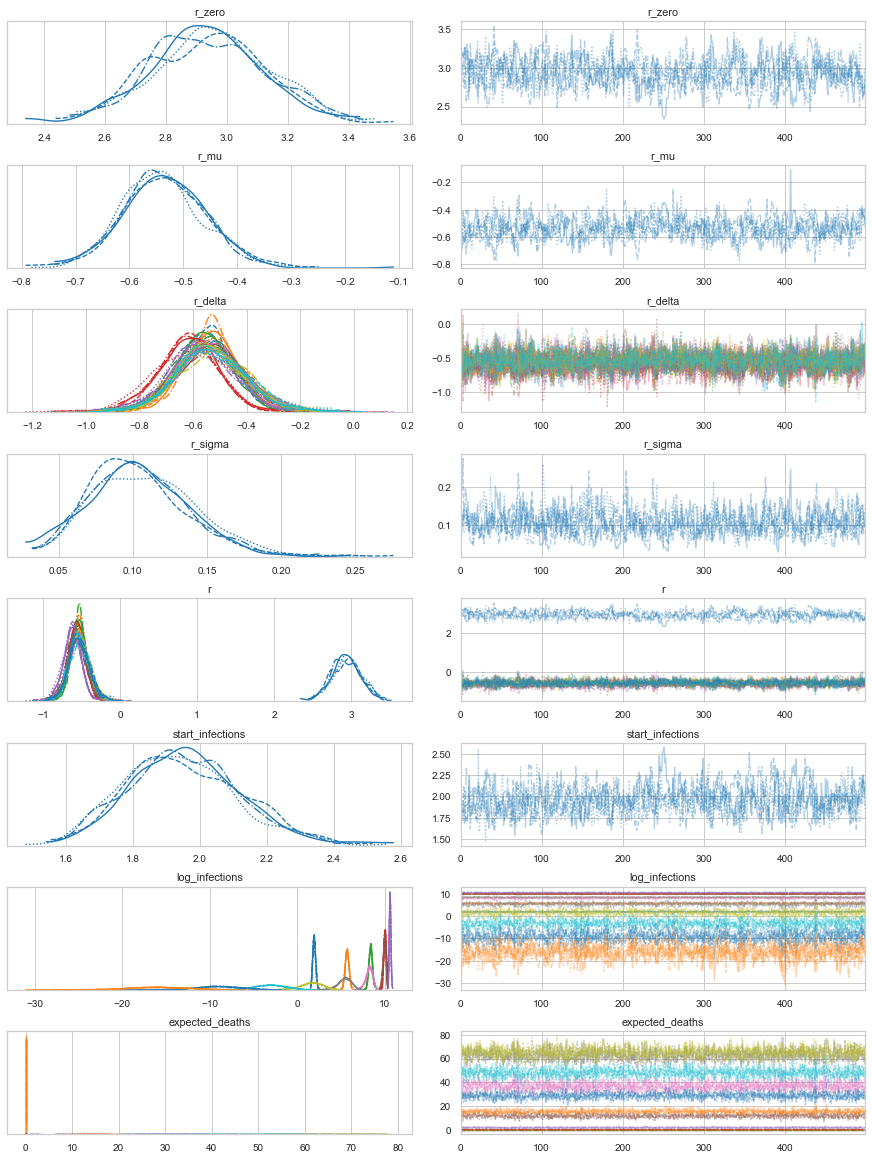

In [90]:
_ = pm.traceplot(trace)

In [97]:
posterior = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 80000/80000 [01:09<00:00, 1145.32it/s]


In [262]:

    
rescaled = (pd.DataFrame(posterior['obs']) * case_range  + df_input[:data_end]['New Cases'].min())
model_with_quantiles(rescaled, 0.05, list((change_points[1:] * n_days).astype(int)))

plt.plot((df_input[:data_end]['New Cases'].values), label='Johns Hopkins')
plt.legend()
# plt.yscale('log')

KeyError: 'obs'

## Distribution Playground

-21.380568108334575 20.34590921717659


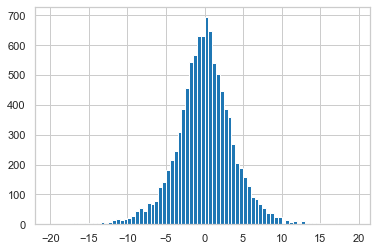

In [114]:
with pm.Model():
    b = pm.Gamma('hyper_beta', 7, 2)
    a = pm.Normal('beta', 0, b).random(size=10000)
    pd.Series(a).hist(bins=np.arange(-20, 20, 0.5))
    print(a.min(), a.max())

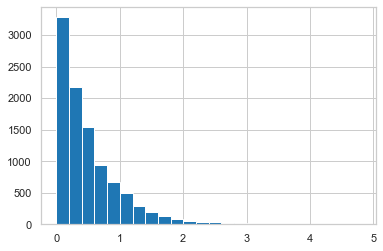

In [157]:
with pm.Model():
    a = pm.Gamma('gamma', 1, 2).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 5, 0.2))

In [620]:
a.min()

999999994448501504